In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from pathlib import Path
from xml.dom.minidom import parse
# import xmltodict
# XML을 json처럼 parsing
from tqdm.auto import tqdm
# 오래걸리는 반복문 시각화
from shutil import copyfile

In [ ]:
!pip install xmltodict

In [2]:
!git clone https://github.com/rkuo2000/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 3387, done.
remote: Total 3387 (delta 0), reused 0 (delta 0), pack-reused 3387
Receiving objects: 100% (3387/3387), 7.02 MiB | 28.74 MiB/s, done.
Resolving deltas: 100% (2271/2271), done.
/content/yolov5


In [3]:
!mkdir -p Dataset/FaceMask/Images
!mkdir -p Dataset/FaceMask/Labels

In [7]:
!cp -rf /content/drive/MyDrive/Colab\ Notebooks/mask_dataset/images/ /content/yolov5/Dataset/FaceMask/Images
# !cp -rf drive/MyDrive/Colab\ Notebooks/mask_dataset/merge_image/* yolov5/Dataset/FaceMask/Images
# image_target_path = '/content/yolov5/Dataset/FaceMask/Images/'
# copy_files('/content/drive/MyDrive/Colab Notebooks/mask_dataset/images/',image_target_path)

In [8]:
FILE_ROOT = "/content/drive/MyDrive/Colab Notebooks/mask_dataset/"
IMAGE_PATH = FILE_ROOT + "images"  
ANNOTATIONS_PATH = FILE_ROOT + "annotations"

DATA_ROOT = "/content/yolov5/Dataset/"
LABELS_ROOT = DATA_ROOT + "FaceMask/Labels"
IMAGES_ROOT = DATA_ROOT + "FaceMask/Images/images/"  

DEST_IMAGES_PATH = "images"
DEST_LABELS_PATH = "labels" 

In [9]:
classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']

In [10]:
def cord_converter(size, box):
    """
    convert xml annotation to darknet format coordinates
    :param size： [w,h]
    :param box: anchor box coordinates [upper-left x,uppler-left y,lower-right x, lower-right y]
    :return: converted [x,y,w,h]
    """
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

def save_file(img_jpg_file_name, size, img_box):
    save_file_name = LABELS_ROOT + '/' + img_jpg_file_name + '.txt'
    # print(save_file_name)
    file_path = open(save_file_name, "a+")
    for box in img_box:

        cls_num = classes.index(box[0])

        new_box = cord_converter(size, box[1:])

        file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

    file_path.flush()
    file_path.close()
    
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    # print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
    # print("img_name:", img_name)
    # print("image_info:(w,h,c)", img_w, img_h, img_c)
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        # print("box:(c,xmin,ymin,xmax,ymax)", cls_name, x1, y1, x2, y2)
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
    # print(img_box)

    # test_dataset_box_feature(img_jpg_file_name, img_box)
    save_file(img_xml_file, [img_w, img_h], img_box)

In [11]:
files = os.listdir(ANNOTATIONS_PATH)
for file in tqdm(files):
    # print("file name: ", file)
    file_xml = file.split(".")
    get_xml_data(ANNOTATIONS_PATH, file_xml[0])

In [12]:
from sklearn.model_selection import train_test_split
image_list = os.listdir(IMAGES_ROOT)
train_list, test_list = train_test_split(image_list, test_size=0.2, random_state=7)
val_list, test_list = train_test_split(test_list, test_size=0.5, random_state=8)

print('total =',len(image_list))
print('train :',len(train_list))
print('val   :',len(val_list))
print('test  :',len(test_list))

total = 853
train : 682
val   : 85
test  : 86


In [13]:
def copy_data(file_list, img_labels_root, imgs_source, type):

    root_file = Path(DATA_ROOT + DEST_IMAGES_PATH + '/' + type)
    if not root_file.exists():
        print(f"Path {root_file} is not exit")
        os.makedirs(root_file)

    root_file = Path(DATA_ROOT + DEST_LABELS_PATH + '/' + type)
    if not root_file.exists():
        print(f"Path {root_file} is not exit")
        os.makedirs(root_file)

    for file in file_list:
        img_name = file.replace('.png', '')
        img_src_file = imgs_source + '/' + img_name + '.png'
        label_src_file = img_labels_root + '/' + img_name + '.txt'

        # print(img_sor_file)
        # print(label_sor_file)
        # im = Image.open(rf"{img_sor_file}")
        # im.show()

        # Copy image
        DICT_DIR = DATA_ROOT + DEST_IMAGES_PATH + '/' + type
        img_dict_file = DICT_DIR + '/' + img_name + '.png'

        copyfile(img_src_file, img_dict_file)

        # Copy label
        DICT_DIR = DATA_ROOT + DEST_LABELS_PATH + '/' + type
        img_dict_file = DICT_DIR + '/' + img_name + '.txt'
        copyfile(label_src_file, img_dict_file)

In [14]:
copy_data(train_list, LABELS_ROOT, IMAGES_ROOT, "train")
copy_data(val_list,   LABELS_ROOT, IMAGES_ROOT, "val")
copy_data(test_list,  LABELS_ROOT, IMAGES_ROOT, "test")

Path /content/yolov5/Dataset/images/train is not exit
Path /content/yolov5/Dataset/labels/train is not exit
Path /content/yolov5/Dataset/images/val is not exit
Path /content/yolov5/Dataset/labels/val is not exit
Path /content/yolov5/Dataset/images/test is not exit
Path /content/yolov5/Dataset/labels/test is not exit


In [15]:
!echo "train: Dataset/images/train\n" > data/facemask.yaml
!echo "val:   Dataset/images/val\n" >> data/facemask.yaml
!echo "nc : 3\n" >> data/facemask.yaml
!echo "names: ['With_Mask', 'Without_Mask', 'Incorrect_Mask']\n" >> data/facemask.yaml

!cat data/facemask.yaml

train: Dataset/images/train\n
val:   Dataset/images/val\n
nc : 3\n
names: ['With_Mask', 'Without_Mask', 'Incorrect_Mask']\n


In [23]:
ls

data/       hubconf.py    README.md*         train.py
Dataset/    LICENSE       requirements.txt*  tutorial.ipynb
detect.py   models/       runs/              utils/
Dockerfile  __pycache__/  test.py            weights/


In [24]:
!python train.py --img 320 --batch 16 --epochs 300 --data data/facemask.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt

Using torch 1.7.0+cu101 CUDA:0 (Tesla P100-PCIE-16GB, 16280MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=False, cfg='models/yolov5s.yaml', data='data/facemask.yaml', device='', epochs=300, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[320, 320], local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', rect=False, resume=False, save_dir='runs/train/exp2', single_cls=False, sync_bn=False, total_batch_size=16, weights='yolov5s.pt', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
2021-01-14 08:48:36.456020: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Hyperparameters {'lr0': 0.01, 'lrf': 0.2, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'wa

In [17]:
ls

data/      Dockerfile  models/       requirements.txt*  tutorial.ipynb
Dataset/   hubconf.py  __pycache__/  test.py            utils/
detect.py  LICENSE     README.md*    train.py           weights/


In [20]:
import yaml
yaml.__version__

'3.13'

In [1]:
!pip install PyYAML

In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -U -r yolov5/requirements.txt  # install dependencies

%cd /content/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 4136 (delta 28), reused 27 (delta 14), pack-reused 4091
Receiving objects: 100% (4136/4136), 7.27 MiB | 33.52 MiB/s, done.
Resolving deltas: 100% (2796/2796), done.
Requirement already up-to-date: Cython in /usr/local/lib/python3.6/dist-packages (from -r yolov5/requirements.txt (line 4)) (0.29.21)
     |████████████████████████████████| 11.6MB 12.1MB/s 
Requirement already up-to-date: numpy>=1.18.5 in /usr/local/lib/python3.6/dist-packages (from -r yolov5/requirements.txt (line 6)) (1.19.5)
     |████████████████████████████████| 50.4MB 103kB/s 
     |████████████████████████████████| 2.2MB 49.6MB/s 
     |████████████████████████████████| 276kB 49.9MB/s 
     |████████████████████████████████| 25.9MB 115kB/s 
Requirement already up-to-date: tensorboard>=2.2 in /usr/local/lib/python3.6/dist-packages (from -r yolov5/

/content/yolov5


In [2]:
!pip freeze

absl-py==0.10.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
argon2-cffi==20.1.0
asgiref==3.3.1
astor==0.8.1
astropy==4.1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.6
atomicwrites==1.4.0
attrs==20.3.0
audioread==2.1.9
autograd==1.3
Babel==2.9.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.2.1
blis==0.4.1
bokeh==2.1.1
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.2.0
catalogue==1.0.0
certifi==2020.12.5
cffi==1.14.4
chainer==7.4.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.2.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda101==7.4.0
cvxopt==1.2.5
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.21
daft==0.0.4
dask==2.12.0
dataclasses==0.8
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.3
distributed==1.25.3
Django==3.1.5
dlib==19.18.0
dm-tree==0.1.5
d

In [3]:
import torch
from IPython.display import Image  # for displaying images
from utils.google_utils import gdrive_download  # for downloading models/datasets

print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

torch 1.7.1 CPU


/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [11]:
!python detect.py --weights weights/best.pt --img 1280 --conf 0.4 --source ../image/

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=1280, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='../image/', update=False, view_img=False, weights=['weights/best.pt'])
/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
YOLOv5 v4.0-14-gb75c432 torch 1.7.1 CPU

Fusing layers... 
Model Summary: 232 layers, 7251912 parameters, 0 gradients, 16.8 GFLOPS
image 1/29 /content/image/0009S6815V3PEU1N-C123

In [5]:
!cp -rf /content/drive/MyDrive/Colab\ Notebooks/mask_dataset/valid/ ../image/

In [7]:
# display detected images
from IPython.display import Image

In [14]:
import matplotlib.pyplot as plt
from glob import glob
testfiles = glob('runs/detect/exp2/*')




In [15]:
img = plt.imread(testfiles[0]) 
plt.imshow(img)    
plt.show

AttributeError: ignored

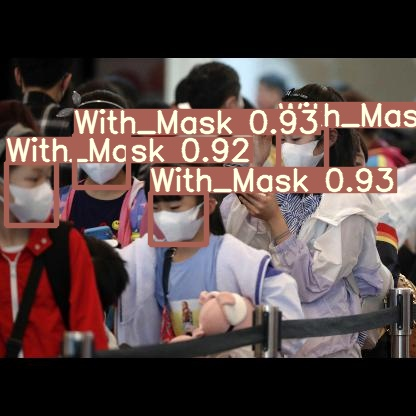

In [16]:
Image('runs/detect/exp2/0009S6815V3PEU1N-C123-F4_jpg.rf.6b0befd018e6308b6029a17a2ee08c48.jpg')

In [9]:
!cp -rf /content/drive/MyDrive/Colab\ Notebooks/mask_dataset/merge_image/ ../image/

In [10]:
!python detect.py --weights weights/best.pt --img 416 --conf 0.4 --source ../image/

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=416, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='../image/', update=False, view_img=False, weights=['weights/best.pt'])
/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
YOLOv5 v4.0-14-gb75c432 torch 1.7.1 CPU

Fusing layers... 
Model Summary: 232 layers, 7251912 parameters, 0 gradients, 16.8 GFLOPS
image 1/29 /content/image/0009S6815V3PEU1N-C123-